In [0]:
from __future__ import absolute_import, division, print_function
import os
from PIL import Image
import random 
import pickle
import json

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from numpy import array
import numpy as np
import cv2
from keras.models import load_model


from keras.utils import np_utils
from collections import defaultdict, namedtuple
from sklearn.model_selection import train_test_split


from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam

tf.logging.set_verbosity(tf.logging.INFO)
from sklearn.metrics import classification_report,confusion_matrix, precision_score, recall_score
import zipfile
from sklearn.utils import shuffle

import skimage.morphology as morp
from skimage.filters import rank

img_size = "10000_images"

In [0]:
effect_type = "BACKLIGHTSUN"
effect_type_2 = "MOTIONBLUR"
effect_type_3 = "DARKNESS"
effect_type_4 = "DIRTLENS"
effect_type_5 = "RAIN"

height = 32
width = 32

all_mixed = ['DARKNESS_RAIN', 'MOTIONBLUR_DARKNESS', 'RAIN_MOTIONBLUR_DARKNESS', 'MOTIONBLUR_RAIN']

file_lookup1 = {"DARKNESS":['DARKNESS_RAIN', 'MOTIONBLUR_DARKNESS', 'RAIN_MOTIONBLUR_DARKNESS'],
               "RAIN":['DARKNESS_RAIN','RAIN_MOTIONBLUR_DARKNESS', 'MOTIONBLUR_RAIN'],
               "MOTIONBLUR":['RAIN_MOTIONBLUR_DARKNESS', 'MOTIONBLUR_RAIN', 'MOTIONBLUR_DARKNESS'], 
               "BACKLIGHTSUN":['BACKLIGHTSUN_DIRTLENS'],
               "DIRTLENS": []
              }


In [238]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
root_path = 'gdrive/My Drive/data_output/'
final_model_path = root_path + "/TSD/h_files/" + "{}.h5".format(effect_type)


# PROCESSES THE TEST DATA 

In [0]:
train_file = root_path + "TSD/p_files/" + "p_files_mixed/{}_FINAL.p".format(effect_type)
effect2_training = root_path + "TSD/p_files/" + "{}_TRAINING.p".format(effect_type_2)
effect3_training = root_path + "TSD/p_files/" + "{}_TRAINING.p".format(effect_type_3)
effect_type_4_training = root_path + "TSD/p_files/" + "{}_TRAINING.p".format(effect_type_4)
effect_type_5_training = root_path + "TSD/p_files/" + "{}_TRAINING.p".format(effect_type_5)


In [241]:
## training data
with open(train_file, mode='rb') as f:
    train = pickle.load(f)

with open(effect2_training, mode='rb') as f:
    effect_2_train = pickle.load(f)    

with open(effect3_training, mode='rb') as f:
    effect_3_train = pickle.load(f)   

with open(effect_type_4_training, mode='rb') as f:
    effect_4_train = pickle.load(f)     
    
with open(effect_type_5_training, mode='rb') as f:
    effect_5_train = pickle.load(f)     
    
X_train, y_train = train['data'], train['quality_data_label']
print("TESTING {}".format(effect_type))


TESTING BACKLIGHTSUN


In [0]:
X_train_2 = effect_2_train['data']
y_train_2 = np.zeros(len(X_train_2))

X_train_3 = effect_3_train['data']
y_train_3 = np.zeros(len(X_train_3))

X_train_4 = effect_4_train['data']
y_train_4 = np.zeros(len(X_train_4))

X_train_5 = effect_5_train['data']
y_train_5 = np.zeros(len(X_train_5))


In [0]:
## TRAINING DATA 
X_train = np.concatenate((X_train, X_train_2, X_train_3, X_train_4, X_train_5))
                        
y_train = np.concatenate((y_train, y_train_2, y_train_3, y_train_4, y_train_5))

In [244]:

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

print(effect_type)
print("TRAINING SET: {}".format(len(X_train)))
print("TRAINING LABELS: {}".format(len(y_train)))
print("TEST SET: {}".format(len(X_test)))
print("TEST LABELS: {}".format(len(y_test)))
print(X_test.shape)

BACKLIGHTSUN
TRAINING SET: 33123
TRAINING LABELS: 33123
TEST SET: 11042
TEST LABELS: 11042
(11042, 32, 32, 3)


In [245]:
test_data_mixed = []
train_data_mixed = []
labels_test_data_mixed = []
labels_train_data_mixed = []


for element in all_mixed:  
    print("TEST DATA")
    print(element)
    test_file = root_path + "TSD/mixed_p_files/" + "{}_TEST.p".format(element) 
    with open(test_file, mode='rb') as f:
        test = pickle.load(f)
    test_data_mixed.append(test['data'])
    if element in file_lookup1.get(effect_type):
        print("Adding mixed classes")
        labels_test_data_mixed.append(test['quality_data_label'])
    else: 
        print("Adding zero classes")
        labels_test = np.zeros(len(test['data']))
        labels_test_data_mixed.append(labels_test)
    
    print("TRAINING DATA")
    train_file = root_path + "TSD/mixed_p_files/" + "{}_TRAINING.p".format(element) 
    with open(train_file, mode='rb') as f:
        train = pickle.load(f)
    train_data_mixed.append(train['data'])
    if element in file_lookup1.get(effect_type):
        print("Adding mixed train classes")
        labels_train_data_mixed.append(train['quality_data_label'])
    else: 
        print("Adding zero train classes")
        labels_train = np.zeros(len(train['data']))
        labels_train_data_mixed.append(labels_train)
    

x_mixed_test = np.concatenate(test_data_mixed)
x_mixed_train = np.concatenate(train_data_mixed)
labels_test_data_mixed = np.concatenate(labels_test_data_mixed)
labels_train_data_mixed = np.concatenate(labels_train_data_mixed)


X_test = np.concatenate((X_test, x_mixed_test))
X_train = np.concatenate((X_train, x_mixed_train))
y_test = np.concatenate((y_test, labels_test_data_mixed))
y_train = np.concatenate((y_train, labels_train_data_mixed))

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

TEST DATA
DARKNESS_RAIN
Adding zero classes
TRAINING DATA
Adding zero train classes
TEST DATA
MOTIONBLUR_DARKNESS
Adding zero classes
TRAINING DATA
Adding zero train classes
TEST DATA
RAIN_MOTIONBLUR_DARKNESS
Adding zero classes
TRAINING DATA
Adding zero train classes
TEST DATA
MOTIONBLUR_RAIN
Adding zero classes
TRAINING DATA
Adding zero train classes
(36723, 32, 32, 3)
(36723,)
(13542, 32, 32, 3)
(13542,)


In [246]:
#print(np.unique(y_test))
num_classes = len(np.unique(y_test))
print("NUMBER OF CLASSES {}".format(num_classes))
print("TRAINING SET: {}".format(len(X_train)))
print("TRAINING LABELS: {}".format(len(y_train)))
print("TEST SET: {}".format(len(X_test)))
print("TEST LABELS: {}".format(len(y_test)))
print("unique{}".format(np.unique(y_test)))

NUMBER OF CLASSES 3
TRAINING SET: 36723
TRAINING LABELS: 36723
TEST SET: 13542
TEST LABELS: 13542
unique[0. 1. 2.]


May want to add preprocessing here

In [247]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

print(num_classes)
Y_train = np_utils.to_categorical(y_train, num_classes)
Y_test = np_utils.to_categorical(y_test, num_classes)
 
## need to add validation data
    
print(X_train.shape)
print(X_test.shape)
print(Y_test.shape)

X_train, Y_train = shuffle(X_train, Y_train)

3
(36723, 32, 32, 3)
(13542, 32, 32, 3)
(13542, 3)


In [0]:
def gray_scale(image):
    """
    Convert images to gray scale.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def local_histo_equalize(image):
    """
    Apply local histogram equalization to grayscale images.
        Parameters:
            image: A grayscale image.
    """
    kernel = morp.disk(30)
    img_local = rank.equalize(image, selem=kernel)
    return img_local

def image_normalize(image):
    """
    Normalize images to [0, 1] scale.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    image = np.divide(image, 255)
    return image


In [249]:
def preprocess(data):
    """
    Applying the preprocessing steps to the input data.
        Parameters:
            data: An np.array compatible with plt.imshow.
    """
    gray_images = list(map(gray_scale, data))
    equalized_images = list(map(local_histo_equalize, gray_images))
    n_training = data.shape
    normalized_images = np.zeros((n_training[0], n_training[1], n_training[2]))
    for i, img in enumerate(equalized_images):
        normalized_images[i] = image_normalize(img)
    #normalized_images = normalized_images[..., None]
    return normalized_images

X_train = preprocess(X_train)
X_test = preprocess(X_test)
X_train = X_train.reshape(X_train.shape[0], 1, width, height)
X_test = X_test.reshape(X_test.shape[0], 1, width, height)

print(X_test.shape)

X_test, X_valid, Y_test, Y_valid = train_test_split(X_test, Y_test, test_size=0.10, random_state=42, shuffle=True)


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


(13542, 1, 32, 32)


In [0]:
# 7. Define model architecture
def create_deep_CNN():

    
    # @toDO: batchnormalization

    model = Sequential()

    #model.add(Convolution2D(32, 3, 3, activation='relu', input_shape=(1,28,28)), data_format='channels_first'))

    model.add(Convolution2D(32, (3, 3), activation='relu', input_shape=(1,width,height), data_format='channels_first'))
    model.add(Convolution2D(32, 3, 3, activation='relu'))
    model.add(Dropout(0.5))
    #keras.layers.Dropout(0.5),
    #model.add(layers.Dense(64, use_bias=False))
    #model.add(BatchNormalization())
    model.add(Activation("relu"))
    
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    ## adds learning rate
    optimizer = Adam(lr=1e-3)

    # 8. Compile model @todo: add more metrics to this 
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy', 'mse'])
    return model

## reshaping for the larger CN


In [251]:
deep_model = create_deep_CNN()

history_deep_cnn = deep_model.fit(X_train, 
                       Y_train, 
                       batch_size=64, 
                       epochs=50, 
                       verbose=1, 
                       shuffle=True,  
                       validation_data = (X_test, Y_test))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
  # This is added back by InteractiveShellApp.init_path()


Train on 36723 samples, validate on 12187 samples
Epoch 1/50
36723/36723 [==============================] - 9s 252us/step - loss: 0.2688 - acc: 0.9019 - mean_squared_error: 0.0481 - val_loss: 0.2048 - val_acc: 0.9210 - val_mean_squared_error: 0.0376
Epoch 2/50
36723/36723 [==============================] - 6s 164us/step - loss: 0.1881 - acc: 0.9316 - mean_squared_error: 0.0339 - val_loss: 0.1667 - val_acc: 0.9409 - val_mean_squared_error: 0.0301
Epoch 3/50
36723/36723 [==============================] - 6s 169us/step - loss: 0.1594 - acc: 0.9420 - mean_squared_error: 0.0291 - val_loss: 0.1573 - val_acc: 0.9385 - val_mean_squared_error: 0.0296
Epoch 4/50
36723/36723 [==============================] - 6s 168us/step - loss: 0.1473 - acc: 0.9455 - mean_squared_error: 0.0270 - val_loss: 0.1463 - val_acc: 0.9457 - val_mean_squared_error: 0.0266
Epoch 5/50
36723/36723 [==============================] - 6s 164us/step - loss: 0.1337 - acc: 0.9499 - mean_squared_error: 0.0247 - val_loss: 0.1444 -

In [252]:
deep_model.save(root_path + "/TSD/h_files/deepCNN" + "{}.h5".format(effect_type))
print("Saved model to disk")

Saved model to disk


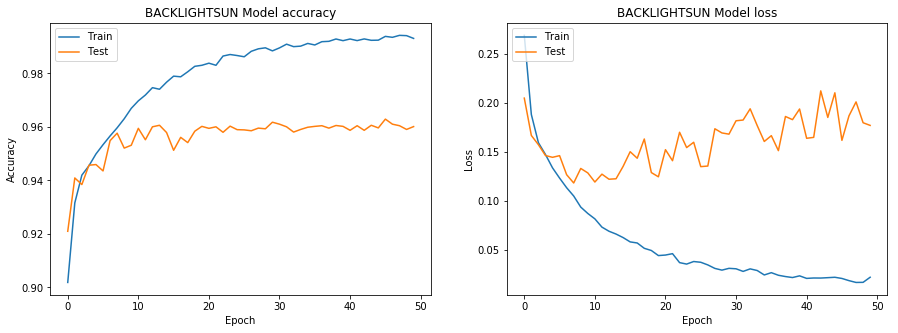

In [253]:
import matplotlib.pyplot as plt

def create_graphs(history):
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('{} Model accuracy'.format(effect_type))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
        #pyplot.show()

    plt.subplot(122)
        # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('{} Model loss'.format(effect_type))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.savefig('gdrive/My Drive/FIGURES/{}_deep_cnn.png'.format(effect_type))
    plt.show()

create_graphs(history_deep_cnn)

In [254]:
## need to fix
score = deep_model.evaluate(X_valid, Y_valid)

1355/1355 [==============================] - 0s 109us/step
[0.1262846299282947, 0.9682656826568266, 0.016994477981944447]


In [255]:
def generate_classification_results(model, X, Y):
    total = len(X)
    print(total)
    y_pred = model.predict(X)
    matrix = confusion_matrix(Y.argmax(axis=1), y_pred.argmax(axis=1))
    print(matrix)
    matrix1 = classification_report(Y.argmax(axis=1), y_pred.argmax(axis=1))
    print(matrix1)
    print("PRECISION {}" .format(precision_score(Y.argmax(axis=1), y_pred.argmax(axis=1), average='macro')))
    print("RECALL {}".format(recall_score(Y.argmax(axis=1), y_pred.argmax(axis=1), average='macro')))
    
generate_classification_results(deep_model, X_test, Y_test)


12187
[[10197    23     4]
 [  207   705   147]
 [   15    90   799]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     10224
           1       0.86      0.67      0.75      1059
           2       0.84      0.88      0.86       904

    accuracy                           0.96     12187
   macro avg       0.89      0.85      0.87     12187
weighted avg       0.96      0.96      0.96     12187

PRECISION 0.8938678650356274
RECALL 0.8489770306850337


# RESNET Approach 
used as a protoype but not selected as it was too heavy


In [160]:
from keras import layers
from keras.models import Model

def _after_conv(in_tensor):
    norm = layers.BatchNormalization()(in_tensor)
    return layers.Activation('relu')(norm)

def conv1(in_tensor, filters):
    conv = layers.Conv2D(filters, kernel_size=1, strides=1)(in_tensor)
    return _after_conv(conv)

def conv1_downsample(in_tensor, filters):
    conv = layers.Conv2D(filters, kernel_size=1, strides=2)(in_tensor)
    return _after_conv(conv)

def conv3(in_tensor, filters):
    conv = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(in_tensor)
    return _after_conv(conv)

def conv3_downsample(in_tensor, filters):
    conv = layers.Conv2D(filters, kernel_size=3, strides=2, padding='same')(in_tensor)
    return _after_conv(conv)

def resnet_block_wo_bottlneck(in_tensor, filters, downsample=False):
    if downsample:
        conv1_rb = conv3_downsample(in_tensor, filters)
    else:
        conv1_rb = conv3(in_tensor, filters)
    conv2_rb = conv3(conv1_rb, filters)

    if downsample:
        in_tensor = conv1_downsample(in_tensor, filters)
    result = layers.Add()([conv2_rb, in_tensor])

    return layers.Activation('relu')(result)

def resnet_block_w_bottlneck(in_tensor,
                             filters,
                             downsample=False,
                             change_channels=False):
    if downsample:
        conv1_rb = conv1_downsample(in_tensor, int(filters/4))
    else:
        conv1_rb = conv1(in_tensor, int(filters/4))
    conv2_rb = conv3(conv1_rb, int(filters/4))
    conv3_rb = conv1(conv2_rb, filters)

    if downsample:
        in_tensor = conv1_downsample(in_tensor, filters)
    elif change_channels:
        in_tensor = conv1(in_tensor, filters)
    result = layers.Add()([conv3_rb, in_tensor])

    return result

def _pre_res_blocks(in_tensor):
    conv = layers.Conv2D(64, 7, strides=2, padding='same')(in_tensor)
    conv = _after_conv(conv)
    pool = layers.MaxPool2D(3, 2, padding='same')(conv)
    return pool

def _post_res_blocks(in_tensor, n_classes):
    pool = layers.GlobalAvgPool2D()(in_tensor)
    preds = layers.Dense(n_classes, activation='softmax')(pool)
    return preds

def convx_wo_bottleneck(in_tensor, filters, n_times, downsample_1=False):
    res = in_tensor
    for i in range(n_times):
        if i == 0:
            res = resnet_block_wo_bottlneck(res, filters, downsample_1)
        else:
            res = resnet_block_wo_bottlneck(res, filters)
    return res

def convx_w_bottleneck(in_tensor, filters, n_times, downsample_1=False):
    res = in_tensor
    for i in range(n_times):
        if i == 0:
            res = resnet_block_w_bottlneck(res, filters, downsample_1, not downsample_1)
        else:
            res = resnet_block_w_bottlneck(res, filters)
    return res

def _resnet(in_shape=(32,32,1),
            n_classes=1,
            opt='sgd',
            convx=[64, 128, 256, 512],
            n_convx=[2, 2, 2, 2],
            convx_fn=convx_wo_bottleneck):
    in_layer = layers.Input(in_shape)

    downsampled = _pre_res_blocks(in_layer)

    conv2x = convx_fn(downsampled, convx[0], n_convx[0])
    conv3x = convx_fn(conv2x, convx[1], n_convx[1], True)
    conv4x = convx_fn(conv3x, convx[2], n_convx[2], True)
    conv5x = convx_fn(conv4x, convx[3], n_convx[3], True)

    preds = _post_res_blocks(conv5x, n_classes)

    model = Model(in_layer, preds)
    model.compile(loss="categorical_crossentropy", optimizer=opt,
	              metrics=["accuracy"])
    return model

def resnet18(in_shape=(32,32,3), n_classes=num_classes, opt='sgd'):
    return _resnet(in_shape, n_classes, opt)

def resnet34(in_shape=(32,32,3), n_classes=num_classes, opt='sgd'):
    return _resnet(in_shape,
                  n_classes,
                  opt,
                  n_convx=[3, 4, 6, 3])

def resnet50(in_shape=(32,32,1), n_classes=num_classes, opt='sgd'):
    return _resnet(in_shape,
                  n_classes,
                  opt,
                  [256, 512, 1024, 2048],
                  [3, 4, 6, 3],
                  convx_w_bottleneck)

def resnet101(in_shape=(224,224,3), n_classes=1000, opt='sgd'):
    return _resnet(in_shape,
                  n_classes,
                  opt,
                  [256, 512, 1024, 2048],
                  [3, 4, 23, 3],
                  convx_w_bottleneck)

def resnet152(in_shape=(224,224,3), n_classes=1000, opt='sgd'):
    return _resnet(in_shape,
                  n_classes,
                  opt,
                  [256, 512, 1024, 2048],
                  [3, 8, 36, 3],
                  convx_w_bottleneck)

if __name__ == '__main__':
    model = resnet50()
    X_test, Y_test = shuffle(X_test, Y_test)
    X_train = X_train.reshape(X_train.shape[0], width, height, 1)
    X_test = X_test.reshape(X_test.shape[0], width, height, 1)
    
    history = model.fit(X_train, 
                       Y_train, 
                       batch_size=64, 
                       nb_epoch=30, 
                       verbose=1, 
                       shuffle=True,
                       validation_data = (X_test, Y_test))
    model_json = model.to_json()
    with open(root_path + "/TSD/h_files/{}.json".format(effect_type), "w") as json_file:
        json.dump(model_json, json_file)
    model.save_weights(froot_path + "/TSD/h_files/RESNET{}.h5".format(effect_type))
    print("Saved model to disk")

                    
    

W0625 12:36:05.575625 139631077238656 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 27573 samples, validate on 8272 samples
Epoch 1/30
27573/27573 [==============================] - 43s 2ms/step - loss: 2.2236 - acc: 0.8598 - val_loss: 2.2447 - val_acc: 0.8607
Epoch 2/30
27573/27573 [==============================] - 31s 1ms/step - loss: 2.2243 - acc: 0.8620 - val_loss: 2.2447 - val_acc: 0.8607
Epoch 3/30
27573/27573 [==============================] - 31s 1ms/step - loss: 2.2243 - acc: 0.8620 - val_loss: 2.2447 - val_acc: 0.8607
Epoch 4/30
27573/27573 [==============================] - 31s 1ms/step - loss: 2.2243 - acc: 0.8620 - val_loss: 2.2447 - val_acc: 0.8607
Epoch 5/30
27573/27573 [==============================] - 31s 1ms/step - loss: 2.2243 - acc: 0.8620 - val_loss: 2.2447 - val_acc: 0.8607
Epoch 6/30
11776/27573 [===========>..................] - ETA: 16s - loss: 2.1708 - acc: 0.8653

KeyboardInterrupt: ignored